# seq2seq 모델(문장 in & 문장 out)

![](https://aiffelstaticprd.blob.core.windows.net/media/images/GN-4-L-7.max-800x600.jpg)

# encoder 구현

![](https://aiffelstaticprd.blob.core.windows.net/media/images/GN-4-L-6.max-800x600.jpg)

In [ ]:
import tensorflow as tf

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size,embedding_dim)
        self.lstm = tf.keras.layers.LSTM(enc_units) # enc_units = hidden layer size
        

    def call(self, x):
      print('입력 shape :',x.shape) # sample input: 춤 추는 소시지

      x = self.embedding(x)

      print('Embedding Layer를 거친 shape :',x.shape)

      output = self.lstm(x)
      print("LSTM shape의 output shape :",output.shape)

      return output


In [ ]:
vocab_size = 30000
emb_size = 256
lstm_size = 512
batch_size = 1
sample_seq_len = 3

print("Vocab Size : {0}".format(vocab_size))
print("Embedding Size : {0}".format(emb_size))
print("LSTM Size : {0}".format(lstm_size))
print("Batch_size : {0}".format(batch_size))
print("Sample Sequence Length : {0}".format(sample_seq_len))

Vocab Size : 30000
Embedding Size : 256
LSTM Size : 512
Batch_size : 1
Sample Sequence Length : 3


In [ ]:
encoder = Encoder(vocab_size, emb_size, lstm_size)
sample_input = tf.zeros((1, 3))

sample_output = encoder(sample_input)

입력 shape : (1, 3)
Embedding Layer를 거친 shape : (1, 3, 256)
LSTM shape의 output shape : (1, 512)


# decoder 구현

![](https://aiffelstaticprd.blob.core.windows.net/media/images/GN-4-L-7.max-800x600.jpg)

In [ ]:
import tensorflow as tf

In [ ]:
from numpy.lib.shape_base import expand_dims
from tensorflow.python.ops.array_ops import repeat

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.LSTM(dec_units, return_sequences=True)
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.softmax = tf.keras.layers.Softmax(axis=-1)

    def call(self, x, context_v):
        print("입력 shape : ", x.shape)

        x = self.embedding(x)
        print("Embedding layer를 거친 shape", x.shape)

        context_v = tf.repeat(tf.expand_dims(context_v, axis=1), repeats=x.shape[1], axis=1)
        print(context_v.shape)
        x = tf.concat([x, context_v], axis = -1)

        x = self.lstm(x)
        print("LSTM layer의 output layer : ", x.shape)
        print(x)
        output = self.fc(x)
        print("Decoder의 최종 ouput layer : ", output.shape)

        output = self.softmax(output)

        return output

In [ ]:
vocab_size = 30000
emb_size = 256
lstm_size = 512
batch_size = 1
sample_seq_len = 3

print("Vocab Size : {0}".format(vocab_size))
print("Embedding Size : {0}".format(emb_size))
print("LSTM Size : {0}".format(lstm_size))
print("Batch_size : {0}".format(batch_size))
print("Sample Sequence Length : {0}".format(sample_seq_len))

Vocab Size : 30000
Embedding Size : 256
LSTM Size : 512
Batch_size : 1
Sample Sequence Length : 3


In [ ]:
decoder = Decoder(vocab_size, emb_size, lstm_size)
sample_input = tf.zeros((batch_size,sample_seq_len ))

sample_output = decoder(sample_input, sample_output)

입력 shape :  (1, 3)
Embedding layer를 거친 shape (1, 3, 256)
(1, 3, 512)
LSTM layer의 output layer :  (1, 3, 512)
tf.Tensor(
[[[-2.0385056e-03 -5.1894884e-05 -1.2524448e-03 ... -1.1799341e-03
    3.0172719e-03 -7.6975330e-04]
  [-3.0963388e-03 -9.8454890e-05 -2.5970063e-03 ... -2.5136624e-03
    5.4486608e-03 -7.5825263e-04]
  [-3.4734283e-03 -1.7521894e-04 -3.9199004e-03 ... -3.7748676e-03
    7.4258028e-03 -3.0874278e-04]]], shape=(1, 3, 512), dtype=float32)
Decoder의 최종 ouput layer :  (1, 3, 30000)


In [ ]:
sample_output.shape

TensorShape([1, 3, 30000])

In [ ]:
t1 = [[1, 2, 3], [4, 5, 6]]      # dim = 2
t2 = [[7, 8, 9], [10, 11, 12]]   # dim = 2 
tf.concat([t1, t2],1)            # axis = 0


<tf.Tensor: shape=(2, 6), dtype=int32, numpy=
array([[ 1,  2,  3,  7,  8,  9],
       [ 4,  5,  6, 10, 11, 12]], dtype=int32)>

# Attention

- Bahdanau Attention
$$ Score_{alignment} = W * tanh(W_{decoder} * H_{decoder} + W_{encoder} * H_{encoder}) $$

In [ ]:
import tensorflow as tf

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_decoder = tf.keras.layers.Dense(units)
        self.w_encoder = tf.keras.layers.Dense(units)
        self.w_combine = tf.keras.layers.Dense(1)
    
    def call(self, h_encoder, h_decoder):
        print("[H_encoder shape : ", h_encoder.shape)

        h_encoder = self.w_encoder(h_encoder)
        print("[w_encoder x h_encoder shape : ", h_encoder.shape)

        print("[H_decoder shape :", h_decoder.shape)
        h_decoder = tf.expand_dims(h_decoder, 1)
        h_decoder = self.w_decoder(h_decoder)

        print("[w_encoder x h_decoder] shape :", h_decoder.shape)

        score = self.w_combine(tf.nn.tanh(h_decoder + h_encoder))
        print("[score alinment] shape :", score.shape)

        attention_weights = tf.nn.softmax(score, axis=1)
        print("최종 weight : ", attention_weights.numpy())

        context_vector = attention_weights * h_decoder
        context_vector = tf.reduce_sum(context_vector, axis = 1)

        return context_vector, attention_weights

In [ ]:
w_size = 100
print("hidden state {0}차원으로 Mapping ".format(w_size))

attention = BahdanauAttention(w_size)

enc_state = tf.random.uniform((1, 10, 512))
dec_state = tf.random.uniform((1, 512))

_ = attention(enc_state, dec_state)

hidden state 100차원으로 Mapping 
[H_encoder shape :  (1, 10, 512)
[w_encoder x h_encoder shape :  (1, 10, 100)
[H_decoder shape : (1, 512)
[w_encoder x h_decoder] shape : (1, 1, 100)
[score alinment] shape : (1, 10, 1)
최종 weight :  [[[0.12174204]
  [0.06320971]
  [0.09649717]
  [0.15249403]
  [0.13701834]
  [0.10935614]
  [0.05264248]
  [0.0947708 ]
  [0.05711528]
  [0.11515404]]]


![](https://aiffelstaticprd.blob.core.windows.net/media/original_images/GN-4-L-9.jpg)

# Loung Attention

$$ Score(H_{target},H_{source}) = H_{target}^T * W_{combine} * H_{source}$$

In [ ]:
class LuongAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(LuongAttention, self).__init__()
        self.w_combine = tf.keras.layers.Dense(units)

    def call(self, h_encoder, h_decoder):
        print("[h_encoder] shape : ", h_encoder.shape)

        wh = self.w_combine(h_encoder)
        print("[W_encoder x h_encoder] shape :", wh.shape)

        h_decoder = tf.expand_dims(h_decoder, 1)
        alignment = tf.matmul(wh, tf.transpose(h_decoder, [0, 2, 1]))
        print("[Score alignment] shape : ", alignment.shape)

        attention_weights = tf.nn.softmax(alignment, axis = 1)
        print("\n 최종 weight : \n", attention_weights.numpy())

        attention_weights = tf.squeeze(attention_weights, axis= -1)
        context_vector = tf.matmul(attention_weights, h_encoder)

        return context_vector, attention_weights

In [ ]:
emb_dim = 512
attention = LuongAttention(emb_size)

enc_state = tf.random.uniform((1,10,emb_size))
dec_state = tf.random.uniform((1,emb_size))

_ = attention(enc_state, dec_state)

[h_encoder] shape :  (1, 10, 256)
[W_encoder x h_encoder] shape : (1, 10, 256)
[Score alignment] shape :  (1, 10, 1)

 최종 weight : 
 [[[1.40909688e-03]
  [1.25677761e-05]
  [2.89701711e-05]
  [8.43275120e-05]
  [1.27570378e-03]
  [1.16836673e-04]
  [4.67539467e-05]
  [1.15054745e-05]
  [1.74218090e-03]
  [9.95272100e-01]]]


# Softmax

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def softmax(x):
  e_x = np.exp(x - np.max(x))
  return e_x/ e_x.sum()

In [ ]:
pred_logit = np.array([-2,1.5,-1,0.5,2])
pred_prob = softmax(pred_logit)

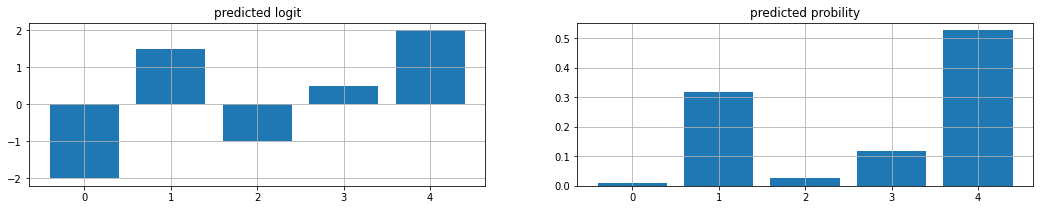

In [ ]:
plt.figure(figsize = [18,3])
plt.subplot(1, 2, 1)
plt.title('predicted logit')
plt.bar(np.arange(len(pred_logit)), pred_logit)
plt.grid()

plt.subplot(1, 2, 2)
plt.title('predicted probility')
plt.bar(np.arange(len(pred_prob)), pred_prob)
plt.grid()
plt.show()